# Lab-3.1: Non-linear curve fitting 

**Author**: J. Hickman

**Instructions** 
* Read and work through all tutorial content and do all exercises below
  
**Submission:**
* You need to upload ONE document to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of this notebook 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

---
format:
    html:
        embed-resources: true
---

**Overview**

* Many supervised learning tasks follow a fairly standardized workflow. 
  * **Step-1)** Define the problem and assemble a dataset
  * **Step-2)** Define a model which can 'capture' the trends in the data.
  * **Step-3)** Divide your data-set into "training" and "validation" sets (to monitor over-fitting)
  * **Step-4)** Prepare your data: This is typically done by normalizing the data, which makes it easier to fit.
  * **Step-5)** Choose a measure of success to gauge the "quality" of a given parameterization of the model
    * For curve fitting the "success" often means finding a model with a low error metric such as mean square error (MSE)
  * **Step-6)** "Train" a model (numerical optimization)
    * For parametric models, training" means doing a "multi-variable" optimization problem to find the model parameters that "best fit" the data 
    * This is done by finding the "best fit" model parameters which minimize some error metric, such as mean square error.
    * If your model is complex enough to over-fit the data, then you will need to regularize the model to prevent over fitting
      *  This last bullet isn't applicable for simple models, however, they become vary important for more complex models such as neural networks.
  * **Step-7)** Use your trained model to make predictions for "new" unseen data points
* This work-flow is often true for both classification and regression problems.
* **The reason we are showing you this is that the workflow maps perfectly onto training many more complicated models, such as neural networks.**
  * **If you understand the workflow below, then you are well on your way to learning how to "train" neural networks, ... more on this in other DSAN classes**
* In this lab we go through this workflow for a simple low dimensional non-linear curve fitting example.


### Import packages 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from   scipy.optimize import minimize
import pandas as pd

### Define the problem and assemble a dataset

* **Define the Problem**: In this lab the goal is to train a parametric model to predict housing price as a function of the distance from a city center. 

**ASSIGNMENT-3.1.1** 
* Write code to read the data set stored in "housing_price.csv"
* Convert `df['distance_east_miles']` into a numpy array called x of shape (N,1)
* Convert `df['housing_price_usd']` into a numpy array called y of shape (N,1)
* Plot the data

Use the following for the axis labels
```
FS=18   #FONT SIZE
plt.xlabel('Distance east (miles)', fontsize=FS)
plt.ylabel('House Price ($) ', fontsize=FS)
```

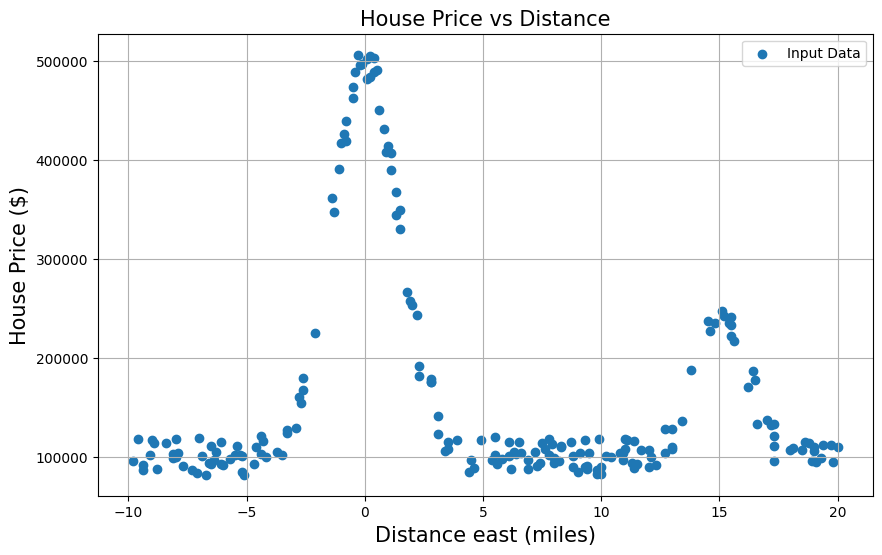

In [5]:
# INSERT CODE TO READ DATA 
df = pd.read_csv("housing_price.csv")

# INSERT CODE TO CONVERT DATA TO NUMPY ARRAYS OF SHAPE (N,1) WHERE N=number of samples
x = df['distance_east_miles'].values.reshape(-1, 1)
y = df['housing_price_usd'].values.reshape(-1, 1)

# INSERT CODE TO PLOT THE FIGURE
fs = 15
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Input Data')
plt.xlabel('Distance east (miles)', fontsize=fs)  
plt.ylabel('House Price ($)', fontsize=fs)        
plt.title('House Price vs Distance', fontsize=fs) 
plt.legend()
plt.grid(True)
plt.show()


### Define a model which can 'capture' the trends in the data.

* The data clearly exhibits bi-modality in the dual "bumps"
  
* Therefore we will use a superposition (sum) of two Gaussian functions to model the two bumps
* This is very similar to what is done in Kernel density estimation (KDE)
* In this case the model parameters actually have geometric interpretations, see the following image

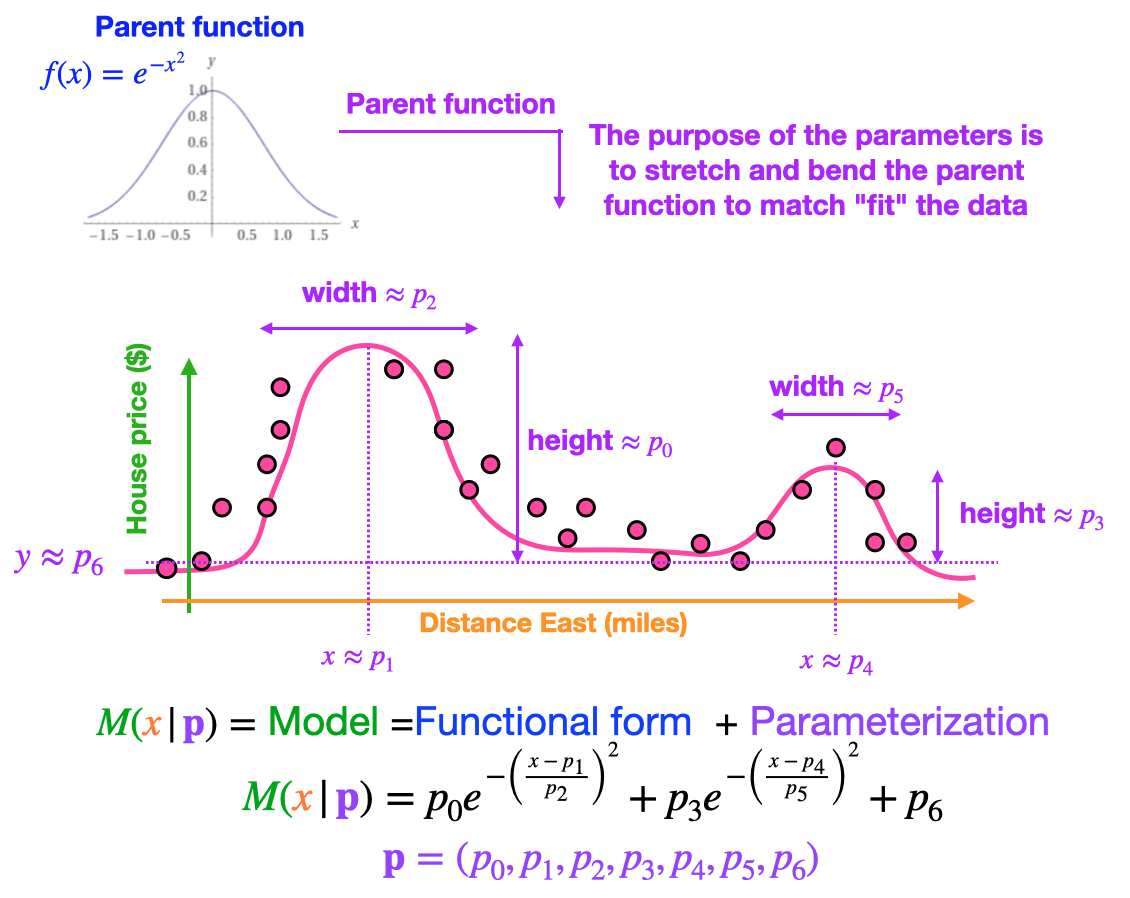

In [4]:
Image(filename='images/image-4.png', width=600)

**Meaning of parameters**

When you are fitting the normalized data, most of the x and y data values should be roughly in the range [-3 to 3].

As discussed in the lecture, the parameters are associated with the stretches and shifts along either the x or y directions.

Therefore the parameters values when fitting the normalized data should also be roughly on the order of [-3 to 3].



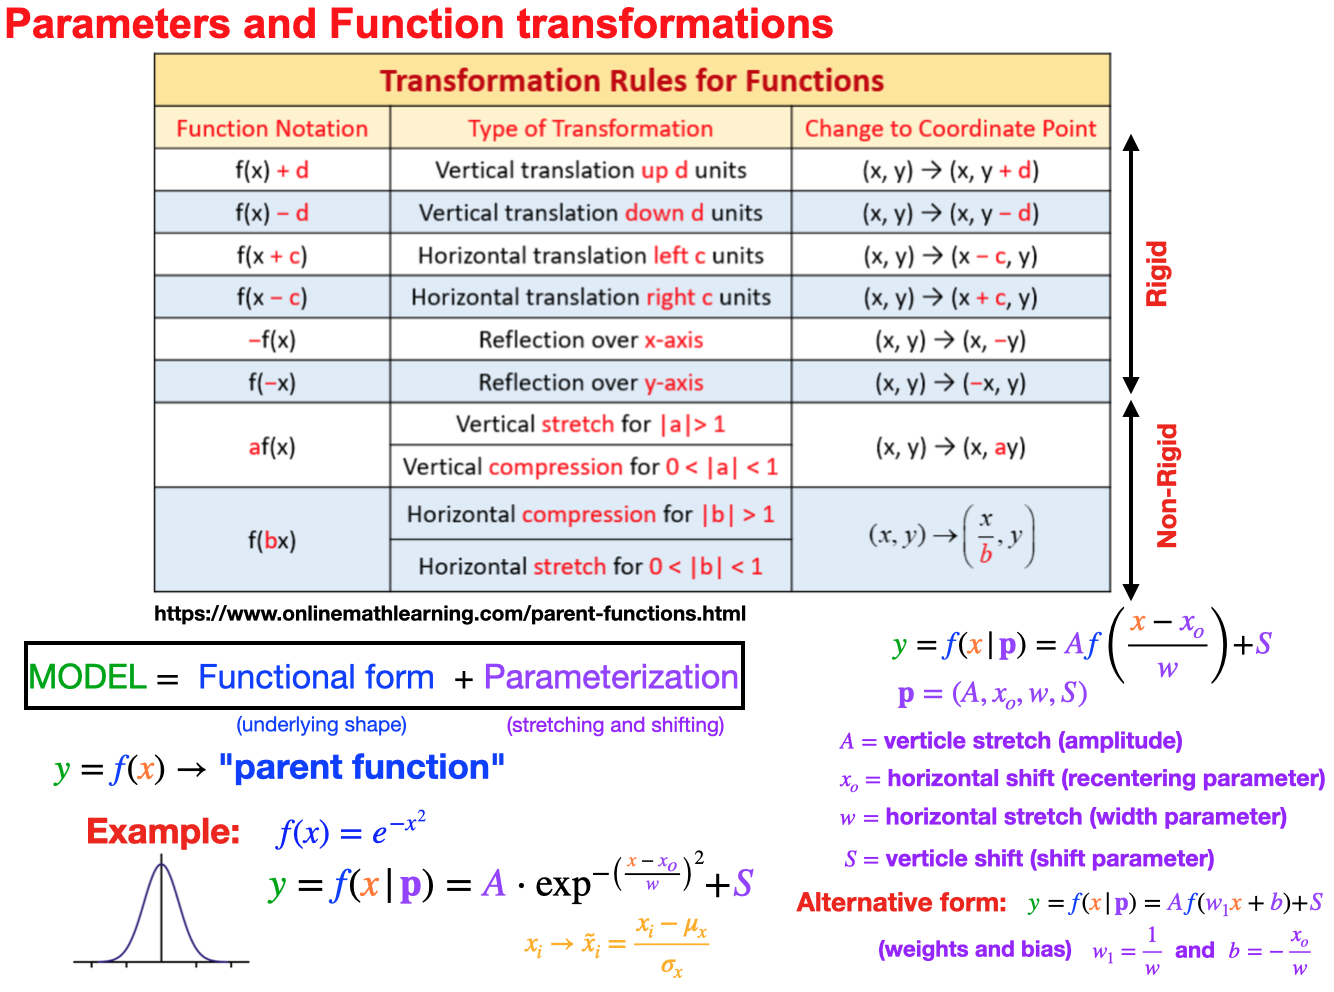

In [46]:
Image(filename='images/image-3.png', width=600)

**ASSIGNMENT-3.1.2** 
* Write code to explore the meaning of the parameters 
* Define a function 'def f1(x,p)' which takes a parameter vector p=[p0,p1,p2,p3] and outputs `p[0]*np.exp(-((x-p[1])**2)/p[2])+p[3]`
* The parent function $e^{-x^2}$ is achieved when the parameter vector is p=[1,0,1,0]
* Generate an array of 100 x values `x1 = np.linspace(-10,10,100)`
* Use this x1 array to generate a single plot showing the following parameterizations of the function
```
ax.plot(x1, f1(x1,[1,0,1,0]), '-', label='[1,0,1,0]')
ax.plot(x1, f1(x1,[1,0,1,-2]),'-', label='[1,0,1,-2]')
ax.plot(x1, f1(x1,[1,-5,1,0]),'-', label='[1,-5,1,0]')
ax.plot(x1, f1(x1,[1,+5,1,0]),'-', label='[1,+5,1,0]')
ax.plot(x1, f1(x1,[1,0,4,0]), '-', label='[1,0,4,0]')
ax.plot(x1, f1(x1,[5,0,1,0]), '-', label='[5,0,1,0]')
```

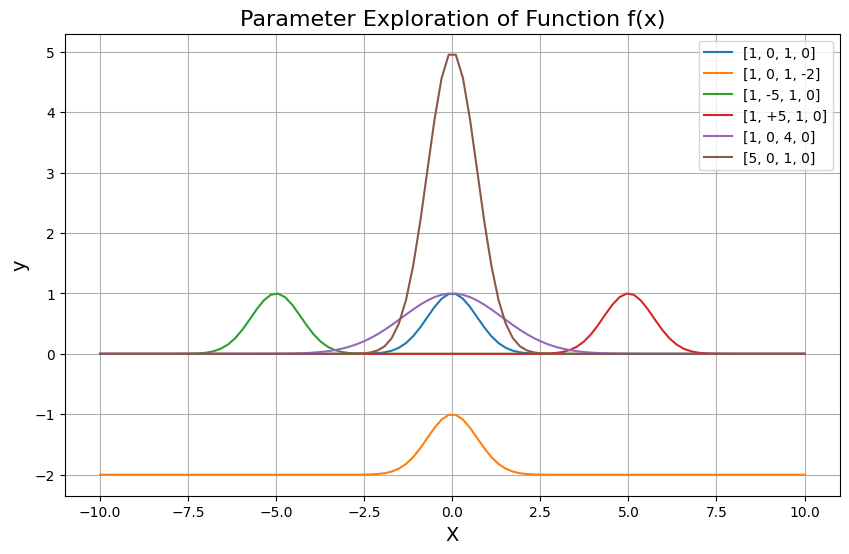

In [6]:
# INSERT CODE HERE
def f1(x, p):
    """
    Calculates the function based on the parameter vector p.
    p[0] = amplitude
    p[1] = horizontal shift
    p[2] = width
    p[3] = vertical shift
    """
    return p[0] * np.exp(-((x - p[1]) ** 2) / p[2]) + p[3]

# Generate an array of 100 x values between -10 and 10
x1 = np.linspace(-10, 10, 100)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# INSERT CODE TO PLOT THE FIGURE
ax.plot(x1, f1(x1, [1, 0, 1, 0]), label='[1, 0, 1, 0]')
ax.plot(x1, f1(x1, [1, 0, 1, -2]), label='[1, 0, 1, -2]')
ax.plot(x1, f1(x1, [1, -5, 1, 0]), label='[1, -5, 1, 0]')
ax.plot(x1, f1(x1, [1, +5, 1, 0]), label='[1, +5, 1, 0]')
ax.plot(x1, f1(x1, [1, 0, 4, 0]), label='[1, 0, 4, 0]')
ax.plot(x1, f1(x1, [5, 0, 1, 0]), label='[5, 0, 1, 0]')

# Add labels, title, and legend
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_title('Parameter Exploration of Function f(x)', fontsize=16)
ax.legend()
ax.grid(True)

# Display the plot
plt.show()


**ASSIGNMENT-3.1.3** 
* Write a "model" function `m(x,p)` which takes a vector of data x, and a parameter vector p.
* The function should return a vector of y values by evaluating the 7 parameter double Gaussian the model shown above

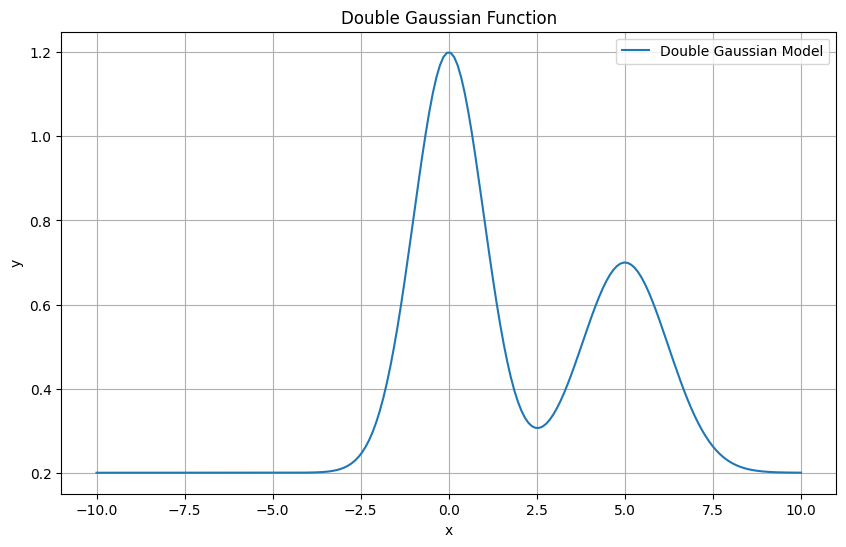

In [8]:
#INSERT CODE
def m(x, p):
    """
    Model function using a double Gaussian model.
    
    Parameters:
    - x: A vector of input data points.
    - p: A parameter vector with 7 elements:
        p[0] = amplitude of the first Gaussian
        p[1] = center of the first Gaussian
        p[2] = width of the first Gaussian
        p[3] = amplitude of the second Gaussian
        p[4] = center of the second Gaussian
        p[5] = width of the second Gaussian
        p[6] = vertical shift (offset)
    
    Returns:
    - A vector of y values computed using the double Gaussian model.
    """
    # Calculate the first Gaussian component
    gaussian1 = p[0] * np.exp(-((x - p[1]) ** 2) / p[2])
    
    # Calculate the second Gaussian component
    gaussian2 = p[3] * np.exp(-((x - p[4]) ** 2) / p[5])
    
    # Combine both Gaussian components and add the vertical shift
    y = gaussian1 + gaussian2 + p[6]
    
    return y

# Generate a range of x values
x_values = np.linspace(-10, 10, 200)

# Define a set of parameters [p0, p1, p2, p3, p4, p5, p6]
params = [1, 0, 2, 0.5, 5, 3, 0.2]

# Calculate y values using the model function
y_values = m(x_values, params)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Double Gaussian Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Double Gaussian Function')
plt.legend()
plt.grid(True)
plt.show()

###  Divide your data-set into "training" and "validation" sets  

**ASSIGNMENT-3.1.4** 
  * Split the data into an 80-20 training-validation set
    * call these `x_train, y_train` and `x_val,   y_val`
  * Plot the training and validation data together (you can copy, tweak, and recycle your code from the plot above)

In [10]:
# INSERT CODE HERE TO SPLIT THE DATA
from sklearn.model_selection import train_test_split

df = pd.read_csv("housing_price.csv")

# Convert columns to numpy arrays
x = df['distance_east_miles'].values.reshape(-1, 1)
y = df['housing_price_usd'].values.reshape(-1, 1)

# Split the data into 80% training and 20% validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

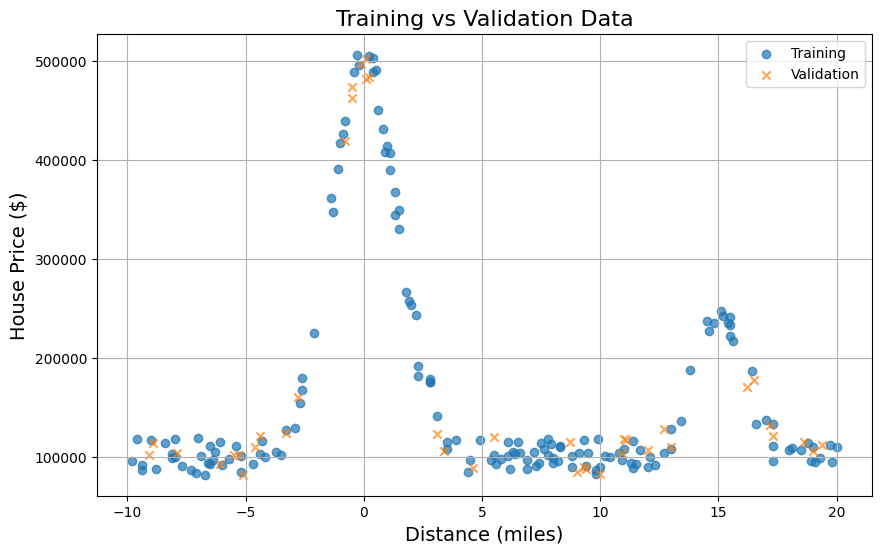

In [11]:
# INSERT CODE HERE TO PLOT THE TRAINING AND VALIDATION SETS
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, label='Training', alpha=0.7)
plt.scatter(x_val, y_val, label='Validation', alpha=0.7, marker='x')

# Adding labels and title
plt.xlabel('Distance (miles)', fontsize=14)
plt.ylabel('House Price ($)', fontsize=14)
plt.title('Training vs Validation Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

### Prepare your data: 

This is typically done by normalizing the data, which makes it easier to fit.


**ASSIGNMENT-3.1.5** 

* Normalize the x data using x --> (x-u_x)/sigma_x
* Normalize the y data using y --> (y-u_y)/sigma_y
* The quantities u_x, u_y, sigma_x and sigma_y should be stored as variables and computed from the training set
* Re-plot the data, notice how numbers on the axis are dramatically different and range roughly -2 to 2. 
* You don't need to include units since the data has no units after normalization

In [13]:
#INSERT CODE HERE TO SAVE MEAN AND STD FOR X AND Y
df = pd.read_csv("housing_price.csv")

# Convert columns to numpy arrays
x = df['distance_east_miles'].values.reshape(-2, 2)
y = df['housing_price_usd'].values.reshape(-2, 2)

# Split the data into training (80%) and validation (20%) sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Calculate mean and standard deviation for x and y using the training set
mu_x = np.mean(x_train)
sigma_x = np.std(x_train)
mu_y = np.mean(y_train)
sigma_y = np.std(y_train)

#TRAINING NORMALIZATION
x_train_norm = (x_train - mu_x) / sigma_x
y_train_norm = (y_train - mu_y) / sigma_y

#VALIDATION NORMALIZATION
x_val_norm = (x_val - mu_x) / sigma_x
y_val_norm = (y_val - mu_y) / sigma_y

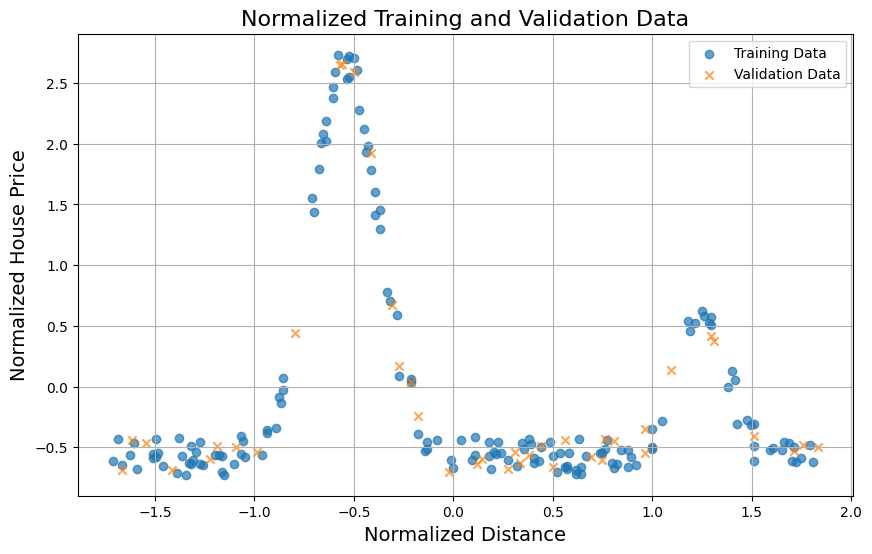

In [16]:
#INSERT CODE HERE TO PLOT NORMALIZED DATA
plt.figure(figsize=(10, 6))
plt.scatter(x_train_norm, y_train_norm, label='Training Data', alpha=0.7)
plt.scatter(x_val_norm, y_val_norm, label='Validation Data', alpha=0.7, marker='x')

# Generate the plot
plt.xlabel('Normalized Distance', fontsize=14)
plt.ylabel('Normalized House Price', fontsize=14)
plt.title('Normalized Training and Validation Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


### Choose a measure of success to gauge the "quality" of a given parameterization of the model
* For our success measure, we will use the mean square error:
  * This is one of the most common regression model error measures.
* **The MSE changes for different parameterization vectors p of our model**
  * Some parameter vectors p=[p0,p1,p2 ... p6] result in good fits of the data, however, most p vectors result in terrible fits.
* The goal of curve fitting is to systematically search through the parameter space p=[p0,p1,p2 ... p6] to find a special set of 7 numbers that minimizes the MSE
  * The parameterization will be our "best fit model" 
  * the numerical search process, i.e. numerical optimization, is called "training"
* For a vector of data `y` and a vector of predictions `ypred=m(x,p)` the MSE is simply np.mean((y-ypred)**2.0))
  * i.e compute the difference between each component of the two y vectors, square the difference, and then take the mean
  
**ASSIGNMENT-3.1.6** 
  * Write an objective function `def loss(p):`, called "loss", that returns the MSE for the training set, given a parameterization vector p for a model.
  * Note the function should use the vector "x_train", for example `ypred=m(x_train,p)`
  * Note that the vector "x_train", defined above, is stored with global scope and can be accessed inside the function.
  * This is the function that we want to minimize, by minimizing the MSE we can find a parameterization of the model which accurately fits the data.
  

In [17]:
# Define the loss function to calculate Mean Squared Error (MSE)
def loss(p):
    """
    Calculates the Mean Squared Error (MSE) for the training set.
    
    Parameters:
    - p: A parameter vector with 7 elements [p0, p1, p2, p3, p4, p5, p6]
    
    Returns:
    - MSE: The mean squared error between the predicted and actual y values
    """
    # Predict y values using the model with parameters p
    y_pred = m(x_train, p)
    
    # Calculate the Mean Squared Error
    mse = np.mean((y_train - y_pred) ** 2)
    
    return mse


### Train your model 

* The following was mentioned above, however, it is important and is worth repeating
* The goal of curve fitting is to systematically search through the parameter space p=[p0,p1,p2 ... p6] to find a special set of 7 numbers that minimizes the MSE
  * The parameterization will be our "best fit model" 
  * the numerical search process, i.e. numerical optimization, is called "training"
* The minimization search which finds the "optimal" parameter vector p=[p0,p1,p2 ... p6] can be done in two ways
  * **Analytical optimization**: i.e. manually do the optimization problem with pen and paper and a lot of calculus 
  * **Numerical optimization:** Use a computer and a numerical optimization algorithm (e.g. the scipy miminizer). This is the option we will use

**ASSIGNMENT-3.1.7** 
* Choose an initial guess for the parameter vector p 
  * When you are fitting the normalized data, most of the x and y data values should be roughly in the range [-3 to 3].
  * As discussed in the lecture, the parameters are associated with the stretches and shifts along either the x or y directions.
  * Therefore the parameters values when fitting the normalized data should also be roughly on the order of [-3 to 3].
  * **YOU WILL LIKELY HAVE TO RUN THE CODE SEVERAL TIMES WITH DIFFERENT RANDOM INITIAL GUESSES BEFORE THE OPTIMIZER FINDS THE OPTIMAL FIT (i.e GLOBAL MINIMA)**
    * Just keep doing "Run All" until you get a fit where both peaks are fit by the model
* Use the Scipy minimizer to minimize the loss function, by varying the components of the parameter vector p, to find the best fit parameters for the model 

```
res = minimize(loss, p0, method='BFGS', tol=1e-5)
popt=res.x
``` 
* when the minimizer is done, it outputs the 7 parameters (i.e. numbers) that correspond to the "best fit" parameters. these are stored in "popt=res.x". 
* To get predictions for this particular parameterization, you need to evaluate the model one last time ypred_opt=m(x_train, popt)
* Make predictions with the fitted model for the test and validation data
* Print the MSE and median percent error for the training AND validation sets (the 0.00001) is included to avoid division by zero

```
print("MSE TRAIN:",np.mean((yp_train-y_train)**2.0))
print("MSE VALIDATION:",np.mean((yp_val-y_val)**2.0))
print("MEDIAN PERCENT ERROR TRAIN:",100*np.median(np.absolute((yp_train-y_train)/(y_train+0.00001))))
print("MEDIAN PERCENT ERROR VALIDATION:",100*np.median(np.absolute((yp_val-y_val)/(y_val+0.00001))))
```
* plot the predictions in the normalized space
* un-normalize the data so that it has units again
* Plot the predictions in the un-normalized space

OPTIMAL PARAMETERS: [-1.64516633e+03  5.46337336e+01  3.46827022e+01 -1.64516633e+03
  5.46337336e+01  3.46827022e+01  5.11472041e+04]
MSE TRAIN: 29409309056.389282
MSE VALIDATION: 24686507342.112522
MEDIAN PERCENT ERROR TRAIN: 53.878591303047784
MEDIAN PERCENT ERROR VALIDATION: 54.15070072882197


C:\Users\USER\AppData\Local\Temp\ipykernel_13332\164245272.py:21: RuntimeWarning: overflow encountered in exp
  gaussian1 = p[0] * np.exp(-((x - p[1]) ** 2) / p[2])
C:\Users\USER\AppData\Local\Temp\ipykernel_13332\164245272.py:24: RuntimeWarning: overflow encountered in exp
  gaussian2 = p[3] * np.exp(-((x - p[4]) ** 2) / p[5])
C:\Users\USER\AppData\Local\Temp\ipykernel_13332\41000674.py:16: RuntimeWarning: overflow encountered in square
  mse = np.mean((y_train - y_pred) ** 2)


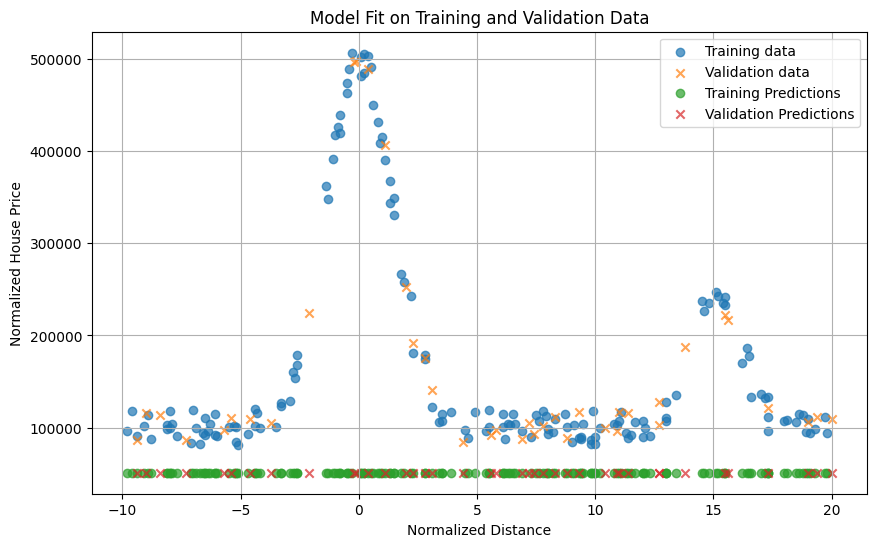

In [19]:

#INSERT CODE FOR A RANDOM INITIAL GUESS
p0 = [1, 0, 1, 1, 0, 1, 0]  # Initial guess for parameters

#INSERT CODE FOR TO TRAIN THE MODEL
res = minimize(loss, p0, method='BFGS', tol=1e-5)
popt = res.x  # Extract the optimized parameters

# Print the optimal parameters found
print("OPTIMAL PARAMETERS:", popt)

##INSERT CODE TO MAKE TRAINING AND VALIDATION PREDICTION USING THE OPTIMAL PARAMETERS
yp_train = m(x_train, popt)
yp_val = m(x_val, popt)

##INSERT CODE TO PRINT THE MSE AND MEAN PERCENT ERROR 
print("MSE TRAIN:",np.mean((yp_train-y_train)**2.0))
print("MSE VALIDATION:",np.mean((yp_val-y_val)**2.0))
print("MEDIAN PERCENT ERROR TRAIN:",100*np.median(np.absolute((yp_train-y_train)/(y_train+0.00001))))
print("MEDIAN PERCENT ERROR VALIDATION:",100*np.median(np.absolute((yp_val-y_val)/(y_val+0.00001))))

# INSERT CODE TO PLOT THE RESULTS IN THE NORMALIZED SPACE
plt.figure(figsize=(10, 6))

# Plot actual training data
plt.scatter(x_train, y_train, label='Training data', alpha=0.7)

# Plot actual validation data
plt.scatter(x_val, y_val, label='Validation data', marker='x', alpha=0.7)

# Plot predictions for training data
plt.scatter(x_train, yp_train, label='Training Predictions', alpha=0.7)

# Plot predictions for validation data
plt.scatter(x_val, yp_val, label='Validation Predictions', marker='x', alpha=0.7)

# Adding labels, title, and legend
plt.xlabel('Normalized Distance')
plt.ylabel('Normalized House Price')
plt.title('Model Fit on Training and Validation Data')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#INSERT CODE TO UN-NORMALIZE THE DATA
yp_train_un = (yp_train * sigma_y) + mu_y  # Convert normalized predictions back to original scale
yp_val_un = (yp_val * sigma_y) + mu_y  # Convert normalized predictions back to original scale

# Un-normalize the training and validation actual values
y_train_un = (y_train * sigma_y) + mu_y
y_val_un = (y_val * sigma_y) + mu_y

# Un-normalize the x values for plotting
x_train_un = (x_train * sigma_x) + mu_x
x_val_un = (x_val * sigma_x) + mu_x




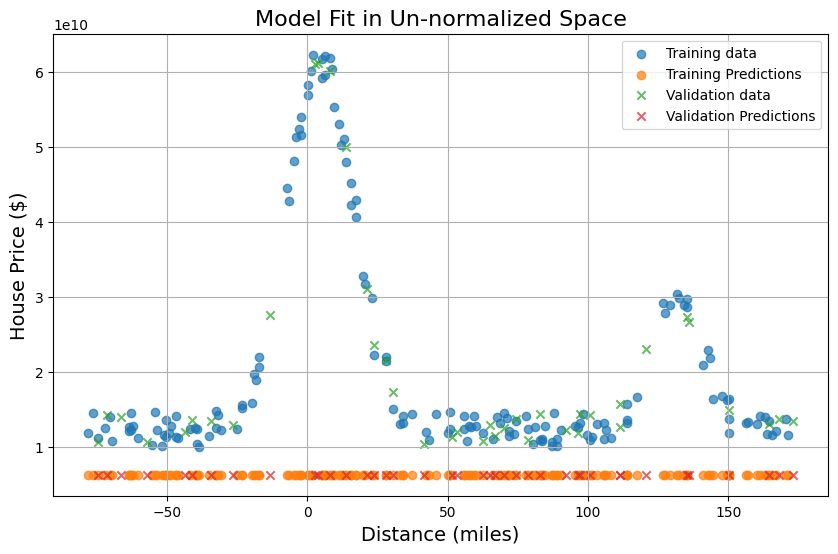

In [28]:
###INSERT CODE TO PLOT THE RESULTS IN THE UN-NORMALIZED SPACE

plt.figure(figsize=(10, 6))

#TRAINING
plt.scatter(x_train_un, y_train_un, label='Training data', alpha=0.7)
# Plot predicted training data in un-normalized space
plt.scatter(x_train_un, yp_train_un, label='Training Predictions', alpha=0.7)

#VALIDATION
# Plot actual validation data in un-normalized space
plt.scatter(x_val_un, y_val_un, label='Validation data', marker='x', alpha=0.7)
# Plot predicted validation data in un-normalized space
plt.scatter(x_val_un, yp_val_un, label='Validation Predictions', marker='x', alpha=0.7)

# Generate Plot
plt.xlabel('Distance (miles)', fontsize=14)
plt.ylabel('House Price ($)', fontsize=14)
plt.title('Model Fit in Un-normalized Space', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


## Extra: Mathematical Optimization 
* For the case of "fitting" parametric models, the "training" consists of a multi-variable optimization problem.
* Therefore, below we show a simple optimization example using SciPy.
* Where the objective function quantifies how 'bad' the model is.

In [57]:
# IMPORT PACKAGES
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from   scipy.optimize import minimize

In [58]:
num_func_eval=1
def f(x):
	global num_func_eval

	#OBJECTIVE FUNCTION
	out=(x+1)**2.0+1.

	#JUST SOME OUTPUT TO MONITOR DURING FITTING
	if(num_func_eval%1==0 and num_func_eval>1):
		print(num_func_eval,"x=",x,"y=",out)

	num_func_eval+=1
	return out


Note that this function, y=f(x)=(x+1)^2+1 has a global minimum at x=-1 and y=1

In [59]:
#DEFINE X DATA FOR PLOTTING
N=1000; xmin=-10; xmax=10
X = np.linspace(xmin,xmax,N)

Plot the objective function

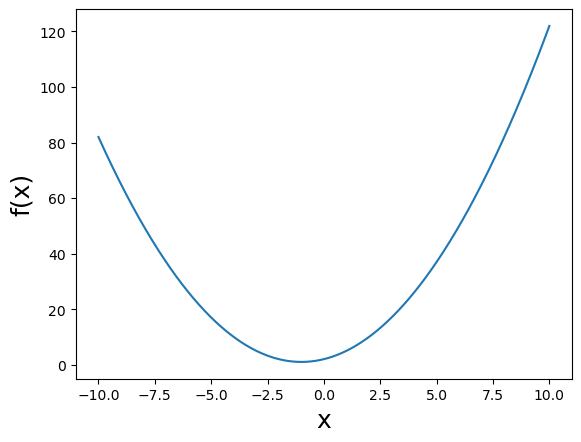

In [60]:
plt.figure() #INITIALIZE FIGURE 
FS=18   #FONT SIZE
plt.xlabel('x', fontsize=FS)
plt.ylabel('f(x)', fontsize=FS)
Y=f(X)
plt.plot(X,Y,'-')

Choose a random initial guess for the location (x value) of the minimum  

In [61]:
#INITIAL GUESS FOR X VALUE 
xo=np.random.uniform(xmin,xmax) 
print("xo = ",xo)

xo =  7.550962957084156


Run the minimizer to find the minimizer  
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [62]:
#RUN OPTIMIZER 
print("INITIAL GUESS: xo=",xo, " f(xo)=",f(xo))
res = minimize(f, xo, method='BFGS', tol=1e-5)
popt=res.x
print("EXPECTED SOLUTION: x = ",-1,"y = 1")


2 x= 7.550962957084156 y= 74.11896749342542
INITIAL GUESS: xo= 7.550962957084156  f(xo)= 74.11896749342542
3 x= [7.55096296] y= [74.11896749]
4 x= [7.55096297] y= [74.11896775]
5 x= [6.54096296] y= [57.86612232]
6 x= [6.54096297] y= [57.86612254]
7 x= [4.3641357] y= [29.77395186]
8 x= [4.36413572] y= [29.77395202]
9 x= [-0.92527037] y= [1.00558452]
10 x= [-0.92527035] y= [1.00558452]
11 x= [-1.00000001] y= [1.]
12 x= [-1.] y= [1.]
EXPECTED SOLUTION: x =  -1 y = 1


13 x= -1.000000010797273 y= 1.0000000000000002


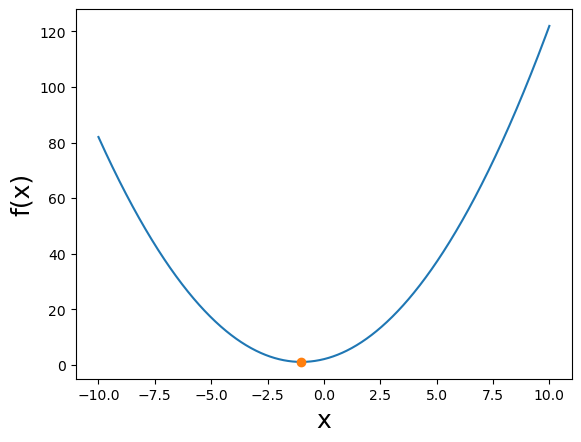

In [63]:
plt.figure() #INITIALIZE FIGURE 
plt.plot(X,Y,'-')
FS=18   #FONT SIZE
plt.xlabel('x', fontsize=FS)
plt.ylabel('f(x)', fontsize=FS)
plt.plot(res.x[0],f(res.x[0]),'o')
plt.show()